# Initial visualization of CYGNSS watermask
## Environments and packages
Chose to use xarray package, not netCDF4, to read the data, so I can view, manipulate, and analyze the data within xarray. I could not use a custom conda environment within Savio Jupyter notebooks, so I am using the base environment with xarray `pip install`ed in my home directory.

Use xarray v0.18.0, but cannot use a conda environment to set this because I don't understand Savio.

## Directory structure
I am reading CYGNSS watermasks from Cynthia's Savio scratch account. There is a 0.01$^\circ$ format and a 0.5$^\circ$ format. For my purposes, I want to always use the 'with_lakes' version. The 0.5$^\circ$ version is a single .nc file while the 0.01$^\circ$ version is a separate .nc file for each month.

# Reading Data 0.5$^\circ$
## Data description 0.5$^\circ$
- Monthly data from 2018-08 to 2022-04 (inclusive)
- xarray indexing order: [lat,lon,time]
- single .nc file

In [1]:
# !pip install xarray --user
import sys
# sys.path.append('/global/home/users/ann_scheliga/.local/lib/python3.7/site-packages/xarray')
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

ImportError: libnetcdf.so.7: cannot open shared object file: No such file or directory

In [2]:
cygnss_filename = 'CYGNSS_watermask_0_5_with_lakes.nc'
cygnss_filepath = '/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/WetCHARTs_size_0_5_deg/'

In [3]:
cygnss_raw = xr.open_dataset(cygnss_filepath+cygnss_filename, decode_times=False)
fw=cygnss_raw['fw']
fw

<xarray.DataArray 'fw' (lat: 151, lon: 721, time: 57)>
[6205647 values with dtype=float32]
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 52.0 53.0 54.0 55.0 56.0
  * lat      (lat) float32 -37.5 -37.0 -36.5 -36.0 -35.5 ... 36.0 36.5 37.0 37.5
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
Attributes:
    long_name:  Monthly fractional surface water (0-100)
    units:      percent water

## Sample map for a single time

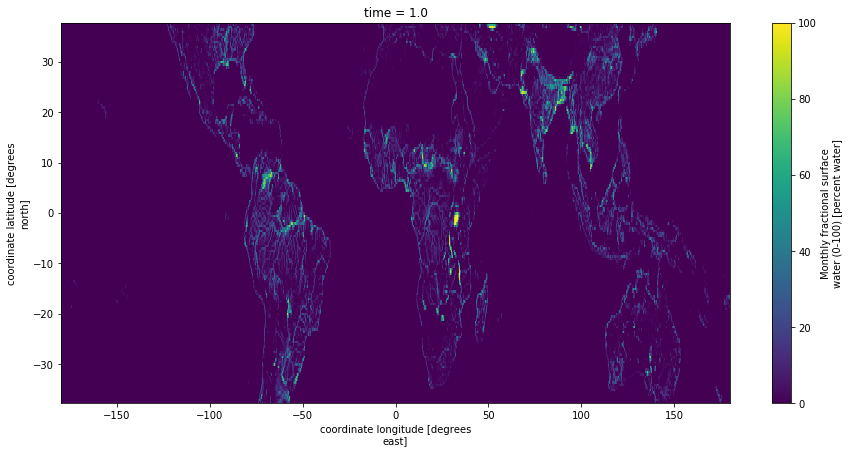

In [4]:
sep2018 = fw[:,:,1]
sep2018.plot(figsize=(15,7))

## Sample time series for a single pixel

In [5]:
merowe = (18.68 , 32.06)
indirasagar = (22.18,76.6)

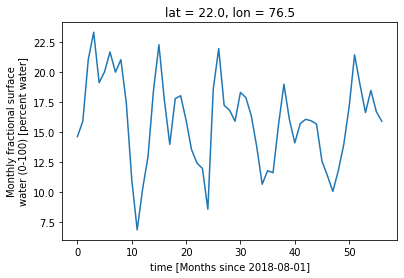

In [6]:
coords_i = (22.18,76.6) # (lat,lon) 
fw.sel(lat=coords_i[0],lon=coords_i[1],method='nearest').plot()

## Time coordinate mainpulations

# Reading data 0.01$^\circ$
## Data description 0.01$^\circ$
- native resolution
- Monthly data from 2018-08 to 2022-04 (inclusive)
- one .nc file per month